In [1]:
import scipy
import numpy as np
from matplotlib import pyplot as plt
import random as rnd
rnd.seed(42)

from utils import (
    get_U_matrix,
    get_random_feature,
    simulate_walks_from_all,
    adj_matrix_to_lists,
    frob_norm_error,
)

### Unbiased pointwise estimation of fixed kernels

In [2]:
class GroundtruthKernels:
    """Compute the groundtruth kernel evaluations."""

    def __init__(self) -> None:
        self.functions = {
            1: self.d_regularised_1,
            2: self.d_regularised_2,
            3: self.p_step_rw_2,
            4: self.diffusion,
            5: self.cosine,
        }


    def d_regularised_1(self, U: np.ndarray) -> np.ndarray:
        """d regularised Lapacian kernel with d=1, (1-U)^{-1}"""
        E = np.eye(U.shape[0])
        return np.linalg.inv((E - U))

    def d_regularised_2(self, U: np.ndarray) -> np.ndarray:
        """d regularised Lapacian kernel with d=2, (1-U)^{-2}"""
        E = np.eye(U.shape[0])
        I_minus_U = E - U
        return np.linalg.inv(I_minus_U @ I_minus_U)

    def p_step_rw_2(self, U: np.ndarray) -> np.ndarray:
        """p step RW kernel with d=2, (1+U)^2"""
        E = np.eye(U.shape[0])
        I_plus_U = E + U
        return I_plus_U @ I_plus_U

    def diffusion(self, U: np.ndarray) -> np.ndarray:
        """Diffusion kernel, exp(U)"""
        return scipy.linalg.expm(U)

    def cosine(self, U: np.ndarray) -> np.ndarray:
        """Cosine kernel, sqrt{2}cos(pi/4-U) = cos(U) + sin(U)."""
        return scipy.linalg.sinm(U) + scipy.linalg.cosm(U)

    def get_groundtruth_kernel(self, func_type: int, U: np.ndarray) -> np.ndarray:
        """
        Get the result of the given kernel.

        Args:
            func_type (int): The type of kernel function to compute (1 to 5).
            U (np.ndarray): The input matrix.
        """
        if func_type not in self.functions:
            raise ValueError(f"Function type {func_type} is not supported.")
        return self.functions[func_type](U)


class ModulationFunctions:
    """
    Modulation functions to generate GRFs, based on inverse convolution of Taylor expansion.
    """

    def __init__(self) -> None:
        self.functions = {
            1: self.d_regularised_1,
            2: self.d_regularised_2,
            3: self.p_step_rw_2,
            4: self.diffusion,
            5: self.cosine,
        }

    def d_regularised_1(self, x: int) -> float:
        """d regularised Lapacian kernel with d=1, (1-U)^{-1}"""
        if x == 0:
            return 1
        else:
            return scipy.special.factorial2(2 * x - 1) / (scipy.special.factorial2(2 * x))

    def d_regularised_2(self, x: int) -> float:
        """d regularised Lapacian kernel with d=2, (1-U)^{-2}"""
        return 1

    def p_step_rw_2(self, x: int) -> float:
        """p step RW kernel with d=2, (1+U)^2"""
        return scipy.special.binom(1, x)

    def diffusion(self, x: int) -> float:
        """Diffusion kernel, exp(U)"""
        return 1 / (2**x * scipy.special.factorial(x))

    def alpha_func_cosine(self, k: int) -> float:
        return (-1) ** (k // 2) / scipy.special.factorial(k)

    def get_next_f_cosine(self, g_eval: float) -> float:
        """Helper function for computing next f function evaluation."""

        f0 = self.f_list[0]
        f1 = self.f_list[1:]
        f1_np = np.asarray(f1)
        f1r_np = f1_np[::-1]
        f1dot = np.dot(f1_np, f1r_np)
        fnext = (g_eval - f1dot) / (2 * f0)
        self.f_list.append(fnext)

        return fnext

    def cosine(self, x: int) -> float:
        """
        Cosine kernel, sqrt{2}cos(pi/4-U) = cos(U) + sin(U).
        Here, there isn't a convenient closed form so we use the iterative formula in Eq. 6
        * Optimized with caching *
        """
        if not hasattr(self, "f_list"):
            self.f_list = [1.0]
        if x < len(self.f_list):
            return self.f_list[x]
        else:
            max_known = len(self.f_list) - 1
            for i in range(max_known, x):
                self.get_next_f_cosine(self.alpha_func_cosine(i + 1))
            return self.f_list[-1]

    def get_modulation(self, func_type: int, x: int) -> float:
        """
        Get the result of the modulation function of the given type.

        :param func_type: The type of modulation (1 to 5).
        :param x: The input integer.
        :return: The result of the modulation function as a float.
        """
        if func_type not in self.functions:
            raise ValueError(f"Invalid function type {func_type}. Must be between 1 and 5.")
        return self.functions[func_type](x)

In [3]:
ground_truth = GroundtruthKernels()
modulation_funcs = ModulationFunctions()

# 8 example graphs
adj_matrices = np.load("data/adj_matrices.npy", allow_pickle=True)

In [4]:
# Choose the hyperparameters.
sigma = 0.5  # Scalar regulariser <1 to ensure that the groundtruth kernels converge
p_halt = 0.5  # Walker termination probability
nb_random_walks = [2, 4, 8, 16]  # Numbers of random walks /node to sample.
trials = 10 # Number of repeats per number of walks per graph.

In [5]:
# Approximate the graph kernels using the GRFs method.

# Holders for approximation error means and standard deviations.
graphs_all_means = []
graphs_all_stds = []

for graph_id, W in enumerate(adj_matrices, start=1):
    print(f"Approximating kernels for graph {graph_id} of 8...")
    all_errors = []
    all_stds = []

    for kernel_index in range(1, 6):
        U = get_U_matrix(W, sigma)  # Normalise the adjacency matrix
        groundtruth = ground_truth.get_groundtruth_kernel(
            kernel_index, U
        )  # Compute groundtruth kernel
        adj_lists, weight_lists = adj_matrix_to_lists(U)  # Get the adjacency and weights lists

        # Instantiate lists to hold errors
        errors_log = []
        stds_log = []

        for walks in nb_random_walks:
            errors = []

            for trial in range(trials):
                all_walks_list = simulate_walks_from_all(adj_lists, p_halt, walks)  # Compute the walks
                A = get_random_feature(
                    U, adj_lists, p_halt, all_walks_list, modulation_funcs.functions[kernel_index]
                )  # Approximate the Gram matrix using GRFs
                
                # all_walks_list = simulate_walks_from_all(adj_lists, p_halt, walks)  # Compute the walks
                # B = get_random_feature(
                #     U, adj_lists, p_halt, all_walks_list, modulation_funcs.functions[kernel_index]
                # )  # Approximate the Gram matrix using GRFs
                approx_mat = A @ A.T
                errors.append(
                    frob_norm_error(groundtruth, approx_mat)
                )  # Record the approximation error
            errors_log.append(np.mean(errors))
            stds_log.append(np.std(errors) / np.sqrt(trials))

        all_errors.append(errors_log)
        all_stds.append(stds_log)

    all_errors = np.asarray(all_errors)
    all_stds = np.asarray(all_stds)

    graphs_all_means.append(all_errors)
    graphs_all_stds.append(all_stds)

print("Done.")

Approximating kernels for graph 1 of 8...
Approximating kernels for graph 2 of 8...
Approximating kernels for graph 3 of 8...
Approximating kernels for graph 4 of 8...
Approximating kernels for graph 5 of 8...
Approximating kernels for graph 6 of 8...
Approximating kernels for graph 7 of 8...
Approximating kernels for graph 8 of 8...
Done.


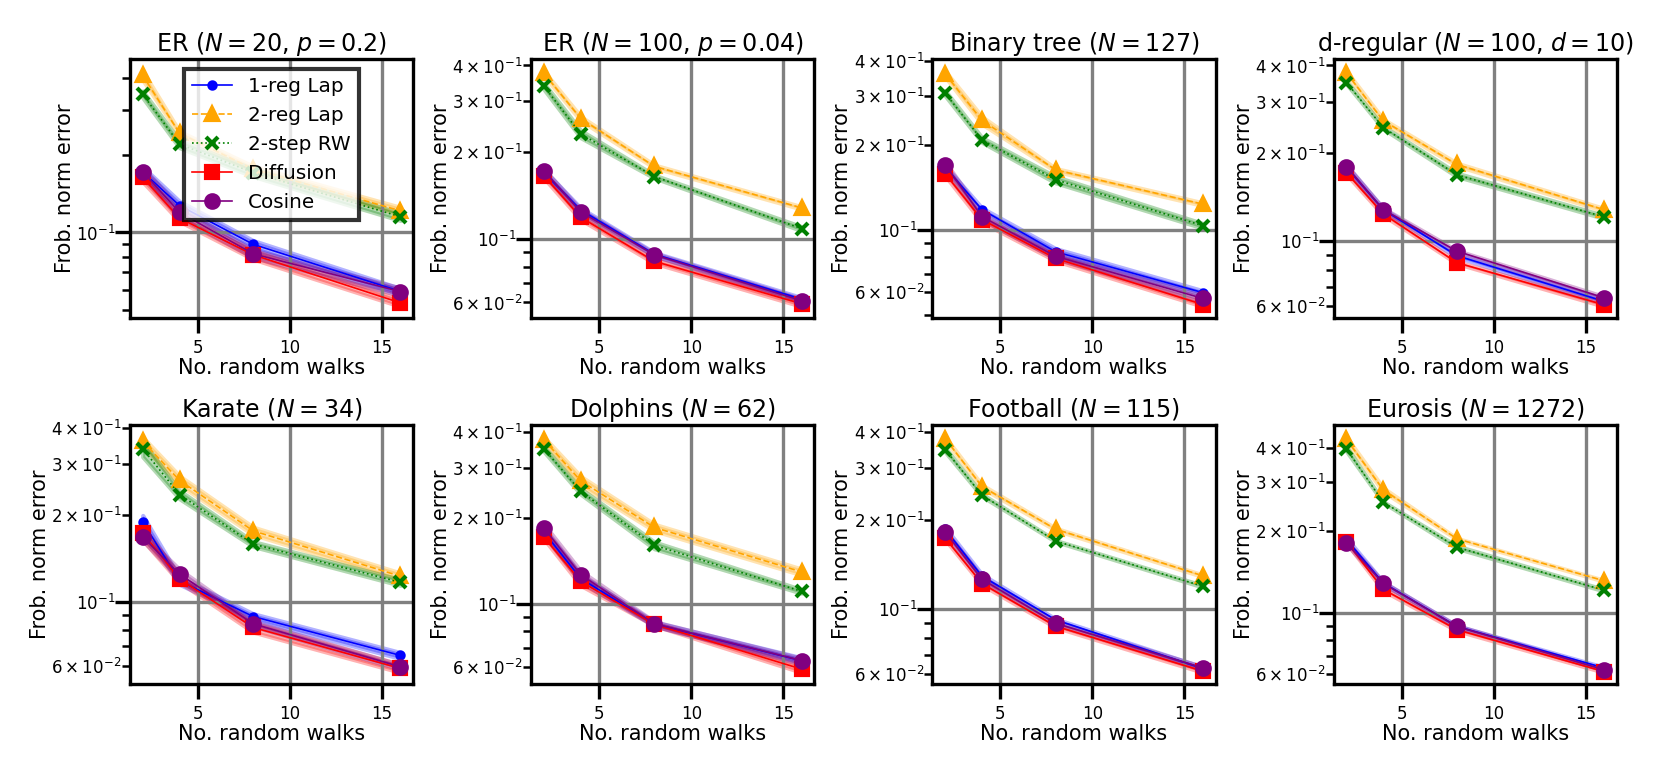

In [6]:
plt.rcParams.update({"font.size": 4})
plt.rcParams["lines.linewidth"] = 0.4
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.minor.pad"] = 0
plt.rcParams["ytick.minor.width"] = 0.6
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 0.8
plt.rcParams["legend.fontsize"] = "large"
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["text.color"] = "black"


def do_single_plot(ax, means, stds, nb_rnd_walks_list):
    """
    Plotting func for data from GRFs experiment.
    """
    linestyles = ["solid", "dashed", "dotted", "solid", "solid"]
    labels = ["1-reg Lap", "2-reg Lap", "2-step RW", "Diffusion", "Cosine"]
    markers = [".", "^", "x", "s", "o"]
    colors = ["blue", "orange", "green", "red", "purple"]

    nb_rnd_walks_list = np.asarray(nb_rnd_walks_list)
    means = np.asarray(means)
    stds = np.asarray(stds)

    for i in range(5):
        ax.plot(
            nb_rnd_walks_list,
            means[i],
            label=labels[i],
            linestyle=linestyles[i],
            marker=markers[i],
            markersize=3,
            color=colors[i],
        )
        ax.fill_between(
            nb_rnd_walks_list, means[i] - stds[i], means[i] + stds[i], alpha=0.3, color=colors[i]
        )

    ax.set_xlabel("No. random walks", labelpad=0.25, size=5, color="black")
    ax.set_ylabel("Frob. norm error", labelpad=0.25, size=5, color="black")
    ax.grid(color="grey")


fig, axes = plt.subplots(2, 4, figsize=(5.41, 2.5), dpi=300)
titles = [
    "ER ($N=20$, $p=0.2$)",
    "ER ($N=100$, $p=0.04$)",
    "Binary tree ($N=127$)",
    "d-regular ($N=100$, $d=10$)",
    "Karate ($N=34$)",
    "Dolphins ($N=62$)",
    "Football ($N=115$)",
    "Eurosis ($N=1272$)",
]

for graph_id, ax in enumerate(axes.flatten()):
    
    do_single_plot(
        ax, 
        graphs_all_means[graph_id], 
        graphs_all_stds[graph_id], 
        nb_random_walks
    )
    
    if graph_id == 0:
        ax.legend()
    ax.set_title(titles[graph_id], pad=2, fontsize=5.7)
    ax.set_yscale("log")


for ax in axes.flatten():
    ax.set_facecolor("white")
    ax.tick_params(colors="black", which="both")  # Set tick colors to black
    ax.spines["bottom"].set_color("black")  # Set bottom spine to black
    ax.spines["left"].set_color("black")  # Set left spine to black
    ax.spines["top"].set_color("black")  # Set bottom spine to black
    ax.spines["right"].set_color("black")  # Set left spine to black


fig.tight_layout() 
plt.show()